# Mounting google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
print(tf.__version__)

2.1.0-dev20191121


# Dataset preparation

## Load data

In [0]:
# open the file as read only
with open('/content/drive/My Drive/Colab Notebooks/text-generation/text-generation-word/nips_clean.txt', 'r') as file:
  corpus = file.read()

In [5]:
words = corpus.split()
n_words = len(words)
unique_words = sorted(list(set(words)))
n_unique_words = len(unique_words)
print("Total number of words:", n_words)
print("Total number of unique words: ", n_unique_words)

Total number of words: 784009
Total number of unique words:  15032


## Parameters configuration

In [0]:
# Parameters configuration
SEQUENCE_LENGTH = 200
MIN_WORD_FREQUENCY = 3 
MAX_VOCAB_SIZE = n_unique_words
EMBEDDING_DIM = 256
BATCH_SIZE = 32
DROPOUT_RATE = 0.2
RNN_UNITS = 128
EPOCHS = 50

In [7]:
# Calculate word frequency
word_count = {}
for word in words:
  word_count[word] = word_count.get(word, 0) + 1

rare_words = set()
for k, v in word_count.items():
  if word_count[k] < MIN_WORD_FREQUENCY:
    rare_words.add(k)

print('Removing words with frequency <', MIN_WORD_FREQUENCY)
print('Total number of rare words: ', len(rare_words))
unique_words = sorted(set(words) - rare_words)
n_unique_words = len(unique_words)
print('Total number of unique words after removing rare words:', n_unique_words)

Removing words with frequency < 3
Total number of rare words:  7066
Total number of unique words after removing rare words: 7966


In [0]:
# Parameters configuration
MAX_VOCAB_SIZE = n_unique_words

## Create sequences of words

In [9]:
# Create sequences of words and remove sequences containing rare words
sequences_words = []
n_ignored = 0
ignored_sequences = []
for i in range(0, n_words - SEQUENCE_LENGTH):
	s = ' '.join(words[i:i+SEQUENCE_LENGTH])	
	# only add sequences containing no rare words
	if len(set(words[i:i+SEQUENCE_LENGTH]).intersection(rare_words)) == 0:
		sequences_words.append(s)
	else:
		n_ignored = n_ignored + 1
		ignored_sequences.append(s)
	
print('Total number of sequences without rare words: %d' % len(sequences_words))
print('Total number of sequences with rare words: %d' % len(ignored_sequences))

Total number of sequences without rare words: 143211
Total number of sequences with rare words: 640598


## Tokenization

In [10]:
# Tokenization
tokenizer = Tokenizer(filters='', lower=False, oov_token="<OOV>")
tokenizer.fit_on_texts(sequences_words)
word_index = tokenizer.word_index

# convert the sequences into integers
sequences = tokenizer.texts_to_sequences(sequences_words)
n_sequences = len(sequences)
# vocabulary size
vocab_size = len(word_index) + 1

print("Number of unique tokens: %d" % len(word_index))
print('Total number of sequences: %d' % n_sequences)

Number of unique tokens: 7204
Total number of sequences: 143211


## Create input and output

In [0]:
# Create input and output 
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]

In [0]:
# Data generator
def generate_arrays(X_all, y_all, batch_size):
    index = 0
    while True:
        x = np.zeros((batch_size, X.shape[1]), dtype=np.int32)
        y = np.zeros((batch_size, vocab_size), dtype=np.bool)
        for i in range(batch_size):
            x[i] = X_all[index]
            y[i] = to_categorical(y_all[index], num_classes = vocab_size)

            index = index + 1
            if index == len(X_all):
               index = 0
               
        yield (x, y)

In [0]:
# Create training set and test set
def shuffle_train_test_split(X_all, y_all, shuffle=True, test_percent=20, random_state=10):
    
    if shuffle:
      X_all_shuffled = []
      y_all_shuffled = [] 
      for i in np.random.RandomState(seed=random_state).permutation(len(X_all)):
          X_all_shuffled.append(X_all[i])
          y_all_shuffled.append(y_all[i])
    else:
      X_all_shuffled = X_all
      y_all_shuffled = y_all

    split_index = int(len(X_all) * (1.-(test_percent/100.)))
    X_train, X_test = X_all_shuffled[:split_index], X_all_shuffled[split_index:]
    y_train, y_test = y_all_shuffled[:split_index], y_all_shuffled[split_index:]

    X_train = np.array(X_train)    
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [0]:
X_train, y_train, X_test, y_test = shuffle_train_test_split(X, y, test_percent=0)

# Modeling

## Building the model

In [15]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=SEQUENCE_LENGTH-1))
model.add(Bidirectional(LSTM(units=RNN_UNITS)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(units=vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 199, 256)          1844480   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 7205)              1851685   
Total params: 4,090,405
Trainable params: 4,090,405
Non-trainable params: 0
_________________________________________________________________
None


## Compile the model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Define the checkpoint

In [0]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
callbacks_list = [early_stopping]

## Train the model

In [18]:
model.fit(generate_arrays(X_train, y_train, BATCH_SIZE),
                    steps_per_epoch = (len(X) // BATCH_SIZE) + 1,
                    epochs = EPOCHS,
                    callbacks = callbacks_list)

  ...
    to  
  ['...']
Train for 4476 steps
Epoch 1/50
4476/4476 [==============================] - 178s 40ms/step - loss: 5.7886 - accuracy: 0.1478
Epoch 2/50
4476/4476 [==============================] - 177s 39ms/step - loss: 5.0200 - accuracy: 0.2075
Epoch 3/50
4476/4476 [==============================] - 177s 40ms/step - loss: 4.5974 - accuracy: 0.2345
Epoch 4/50
4476/4476 [==============================] - 178s 40ms/step - loss: 4.2549 - accuracy: 0.2575
Epoch 5/50
4476/4476 [==============================] - 174s 39ms/step - loss: 3.9021 - accuracy: 0.2827
Epoch 6/50
4476/4476 [==============================] - 177s 40ms/step - loss: 3.6072 - accuracy: 0.3112
Epoch 7/50
4476/4476 [==============================] - 178s 40ms/step - loss: 3.2914 - accuracy: 0.3456
Epoch 8/50
4476/4476 [==============================] - 177s 40ms/step - loss: 3.0484 - accuracy: 0.3780
Epoch 9/50
4476/4476 [==============================] - 177s 40ms/step - loss: 2.7921 - accuracy: 0.4123
Epoch 10/

# Evaluation

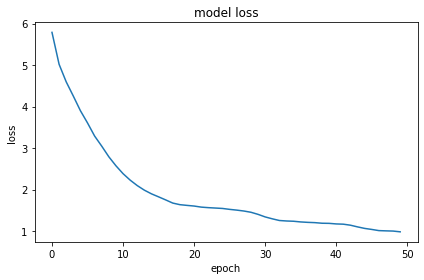

In [31]:
# Plot loss curves
fig = plt.figure()
plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()

# Save data to files

In [0]:
from pickle import dump
# save the tokenizer to file
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [0]:
# save sequences to file
data = '\n'.join(sequences_words)
with open("sequences_words.txt", 'w') as file:
  file.write(data)

In [0]:
# save the model to file
model.save('model.h5')